In [13]:
import pandas as pd
import numpy as np

outputRec = pd.DataFrame({
    "Combination": [],
    "Count": []
})


In [14]:
import heapq
import os
import openpyxl

def Partition(file_name, dim, start_row, end_row, dataCount, pageSize):
    workbook = openpyxl.load_workbook(file_name)
    worksheet = workbook.active
    tempFileNames = []

    line_number = 0
    pageIndex = 0
    df = pd.DataFrame()
    for row in worksheet.iter_rows(min_row=start_row+2, max_row=end_row+2, values_only=True):
        if line_number >= pageSize:
            df.sort_values(by=df.columns[dim], inplace=True)
            tempFileName = "../data/temporary/" + str(pageIndex) + ".xlsx"
            df.to_excel(tempFileName, index=False, header=False)
            tempFileNames.append(tempFileName)
            line_number = 0
            pageIndex += 1
            df = pd.DataFrame()

        df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)
        line_number += 1

    if line_number > 0:
        df.sort_values(by=df.columns[dim], inplace=True)
        tempFileName = "../data/temporary/" + str(pageIndex) + ".xlsx"
        df.to_excel(tempFileName, index=False, header=False)
        tempFileNames.append(tempFileName)
        pageIndex += 1

    min_heap = []

    workbooks = [openpyxl.load_workbook(tempFileName) for tempFileName in tempFileNames]
    file_handles = [workbook.active for workbook in workbooks]
    iterators = [file.iter_rows(values_only=True) for file in file_handles]
    current_row = start_row+2

    # Push the <value, pageid, row> of the first row of each file_handle to the min heap
    for i, iterator in enumerate(iterators):
        first_row = next(iterator)
        heapq.heappush(min_heap, (first_row[dim], i, first_row))

    # While the heap is not empty
    while len(min_heap) > 0:
        value, file_index, row = heapq.heappop(min_heap)

        for col_index, cell_value in enumerate(row):
            worksheet.cell(row=current_row, column=col_index + 1, value=cell_value)

        current_row += 1  
    
        dataCountLength = len(dataCount)
        if dataCountLength == 0:
            dataCount[value] = 1
        elif value in dataCount:
            dataCount[value] += 1
        else:
            dataCount[value] = 1

        # Read the next row from the file of index page_index if it is not empty
        try:
            next_row = next(iterators[file_index])
            heapq.heappush(min_heap, (next_row[dim], file_index, next_row))
        except StopIteration:
            # The file is empty, no more rows to read from it
            continue

    # Save the changes to the original workbook
    workbook.save(file_name)

    workbook.close()
    for workbook in workbooks:
        workbook.close()

     # Delete all the temporary files
    for tempFileName in tempFileNames:
        os.remove(tempFileName)


In [15]:
def count_total_rows(file_name):
    total_rows = 0
    workbook = openpyxl.load_workbook(file_name, read_only=True)

    # Iterate through each worksheet in the workbook
    sheet = workbook.active

    for row in sheet.iter_rows(values_only=True):
        total_rows += 1
        
    # Close the workbook
    workbook.close()

    return total_rows - 1

In [16]:
def BottomUpCube(input, dim, start_row, end_row, currentCombination, numDims, minSup, pageSize):
    global outputRec

    if dim == 0:
        count = count_total_rows(input)
        if count >= minSup:
            outputRec = pd.concat([pd.DataFrame(outputRec), pd.DataFrame([{"Combination": [], "Count": count}])], ignore_index=True)
        
    for d in range(dim, numDims):
        dataCount = {}
        Partition(input, d, start_row, end_row, dataCount, pageSize)

        k = start_row
        for value, c in dataCount.items():
            if c >= minSup:
                outputRec = pd.concat([pd.DataFrame(outputRec), pd.DataFrame([{
                    "Combination": currentCombination + [value], 
                    "Count": c
                    }])], ignore_index=True)

                BottomUpCube(input, d + 1, k, k + c - 1, currentCombination + [value], numDims, minSup, pageSize)

            k += c    

In [17]:
fileName = "../data/inputs/test.xlsx"
workbook = openpyxl.load_workbook(fileName, read_only=True)
sheet = workbook.active
numDims = sheet.max_column
workbook.close()

pageSize = 1
minSup = 1
BottomUpCube(fileName, 0, 0, count_total_rows(fileName) - 1, [], numDims, minSup, pageSize)

Progress:  25.0
Progress:  50.0
Progress:  75.0
Progress:  100.0


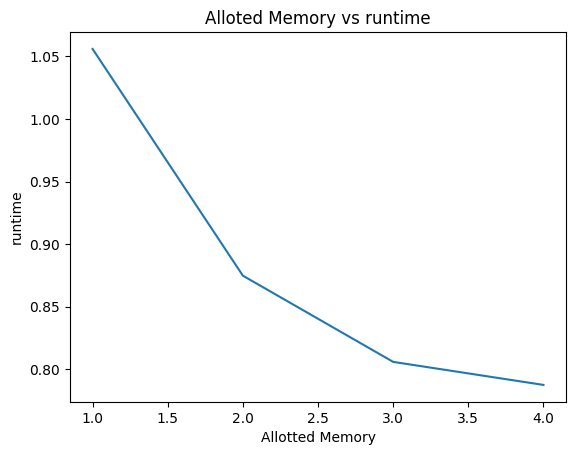

In [18]:
# plot of minsup vs runtime
import time
import matplotlib.pyplot as plt
minsup = 1
pageSize = [1, 2, 3, 4]

runtime = []
numRuns = 5

for idx, s in enumerate(pageSize):
    # calculate runtime of BottomUpCube
    times = []
    for i in range(numRuns):
        start_time = time.time()
        BottomUpCube(fileName, 0, 0, count_total_rows(fileName) - 1, [], numDims, minsup, s)
        times.append(time.time() - start_time)

    runtime.append(sum(times)/len(times))

    # print progress
    print('Progress: ', ((idx + 1)/len(pageSize))*100)
    
plt.plot(pageSize, runtime)
plt.xlabel('Allotted Memory')
plt.ylabel('runtime')
plt.title('Alloted Memory vs runtime')

# save
plt.savefig('../data/outputs/alloted-memory-vs-runtime.png')

plt.show()